# EPI → Saliency → TF‑MoDISco → TOMTOM

This notebook produces **publication-style plots** from:

- `tomtom_large_sample.tsv` (or `tomtom_large_sample/tomtom.tsv`)
- your exported MEME file (optional, to count motifs with *no hit*)
- one saliency `.npy` file (for a representative attribution plot)

> Tip: run top-to-bottom. If a path is wrong, fix it in the **Config** cell and rerun.


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 140


## 0) Config

Edit these paths to match your folder structure.

In [10]:
# === EDIT THESE PATHS ===
TOMTOM_TSV = Path("/Users/igor.ap/Downloads/Courses/Semester_3/Deep_learning/DL_final_ver/modisco_files/tomtom_large_sample.tsv")          # e.g. "tomtom_large_sample/tomtom.tsv"
QUERY_MEME  = Path("big200bp.pos.meme")               # optional, used to count motifs with NO hit
MOTIF_STATS = Path("big200bp.motif_stats.csv")        # optional, if you exported this
SALIENCY_DIR = Path("saliency_scores_2")              # folder with score_*.npy
METADATA_CSV = SALIENCY_DIR / "metadata.csv"          # created by your saliency script

# Parameters used during your window extraction
SEQ_LEN = 65536
WIN = 200
TOPK = 10
MIN_GAP = 200

assert TOMTOM_TSV.exists(), f"Missing TOMTOM file: {TOMTOM_TSV.resolve()}"
print("✅ Found:", TOMTOM_TSV)


AssertionError: Missing TOMTOM file: /Users/igor.ap/Downloads/Courses/Semester_3/Deep_learning/DL_final_ver/examples/.modisco_files/tomtom_large_sample.tsv

## 1) Load TOMTOM results

We read the TSV and normalize column names so the rest of the notebook is robust to slight format differences.

In [3]:
def load_tomtom(tsv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(tsv_path, sep="\t", comment="#")
    # Normalize column names
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

tom = load_tomtom(TOMTOM_TSV)
tom.head()


,query_id,target_id,optimal_offset,p-value,e-value,q-value,overlap,query_consensus,target_consensus,orientation
0,POS_0,MA1712.2,-12,8.480380e-07,0.000864,0.001679,17,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCCCGGGGCCCGGAGCC,-
1,POS_0,MA2546.1,0,5.846910e-06,0.005958,0.005787,13,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCGCGCCCGCGCC,+
2,POS_0,MA2681.1,-25,1.376550e-05,0.014027,0.008645,11,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GGGGGCGGGGC,+
3,POS_0,MA2510.1,-14,1.746760e-05,0.017799,0.008645,18,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GGGGGCCCGCGAGGGGGG,+
4,POS_0,MA2328.1,-29,3.290150e-05,0.033527,0.013026,10,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GCGGGGCGGG,-


In [4]:
# "MA2479.1"  find this in target_id

tom[tom["target_id"] == "MA2479.1"] 


,query_id,target_id,optimal_offset,p-value,e-value,q-value,overlap,query_consensus,target_consensus,orientation


### 1.1 Identify key columns (query id, target id, q-value, overlap)

If this cell errors, paste `tom.columns` and we’ll adapt.

In [5]:
cols = set(tom.columns)

def pick_col(candidates):
    for c in candidates:
        if c in cols:
            return c
    raise KeyError(f"None of these columns found: {candidates}\nAvailable: {sorted(cols)[:40]} ...")

query_col   = pick_col(["query_id","query","query_name"])
target_col  = pick_col(["target_id","target","target_name"])
qval_col    = pick_col(["q-value","q_value","qvalue"])
pval_col    = next((c for c in ["p-value","p_value","pvalue"] if c in cols), None)
eval_col    = next((c for c in ["e-value","e_value","evalue"] if c in cols), None)
overlap_col = next((c for c in ["overlap","overlap_len","overlap_length"] if c in cols), None)

print("query_col  :", query_col)
print("target_col :", target_col)
print("qval_col   :", qval_col)
print("overlap_col:", overlap_col)


query_col  : query_id
target_col : target_id
qval_col   : q-value
overlap_col: overlap


## 2) Best hit per motif + match categories

We keep the **best (lowest q-value) hit** per query motif and bucket it into:

- **TF-matched**: q ≤ 0.05 and overlap ≥ 8
- **Weak**: 0.05 < q ≤ 0.2 or overlap < 8
- **No match**: no hit in TOMTOM (requires the MEME query file to know the full motif list)


In [6]:
best = (tom.sort_values(qval_col, ascending=True)
          .groupby(query_col, as_index=False)
          .first())

# If overlap is missing, treat as NaN (will fall into 'Weak' unless q is very small)
if overlap_col is None:
    best["overlap_tmp"] = np.nan
    overlap_used = "overlap_tmp"
else:
    overlap_used = overlap_col

def classify(q, ov):
    if pd.isna(q):
        return "No match"
    if (q <= 0.05) and (pd.isna(ov) or ov >= 8):
        return "TF-matched"
    if (q <= 0.2):
        return "Weak"
    return "No match"

best["match_class"] = [classify(q, ov) for q, ov in zip(best[qval_col], best[overlap_used])]
best.head()


,query_id,target_id,optimal_offset,p-value,e-value,q-value,overlap,query_consensus,target_consensus,orientation,match_class
0,POS_0,MA1712.2,-12,8.480380e-07,0.000864,0.001679,17,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCCCGGGGCCCGGAGCC,-,TF-matched
1,POS_1,MA0108.3,-32,1.817160e-04,0.185168,0.185933,7,AACTTTAAAAAAATTATTTATTTTAATTTTTGTTTTATAATTTTTA...,TTTTATA,-,Weak
2,POS_10,MA0753.3,-24,1.377660e-04,0.140384,0.062736,10,GGCCGGGGGGAGTTAGTGGCCGGTGTGGGGGGGGGCCGGCAGTGGG...,GTGGGGGGGG,-,Weak
3,POS_11,MA2001.2,-23,1.628340e-04,0.165928,0.330579,7,GATGAGAAGGACGTGGATAAACTTCAGGTTGGTGTTCTAGGATGGC...,TCAGGTT,-,No match
4,POS_12,MA0080.7,-16,1.665080e-04,0.169671,0.338370,13,CAACTGCAGGCACTCTAAAAGGGAAGGGGGACGAGGCTGGTGACGA...,AAAGAGGAAGTGG,+,No match


### 2.1 (Optional) Count motifs with *no hit* using the MEME query file

If you provide `big200bp.pos.meme`, we can add motifs that never appeared in TOMTOM output.

In [7]:
def parse_meme_motif_ids(meme_path: Path):
    if not meme_path.exists():
        return None
    motif_ids = []
    with open(meme_path, "r") as f:
        for line in f:
            if line.startswith("MOTIF"):
                parts = line.strip().split()
                # MEME: 'MOTIF <id> [optional alt]'
                if len(parts) >= 2:
                    motif_ids.append(parts[1])
    return motif_ids

all_query_motifs = parse_meme_motif_ids(QUERY_MEME) if QUERY_MEME.exists() else None

if all_query_motifs is None:
    print("ℹ️ QUERY_MEME not found (or not set). 'No match' will mean q>0.2, not 'no hit'.")
else:
    print("✅ Parsed motifs from MEME:", len(all_query_motifs))
    hit_motifs = set(best[query_col].astype(str))
    missing = [m for m in all_query_motifs if m not in hit_motifs]
    print("Motifs with no TOMTOM hit at all:", len(missing))


✅ Parsed motifs from MEME: 28
Motifs with no TOMTOM hit at all: 0


## 3) Plot: Proportion of motifs with TF matches

/var/folders/1r/8kyrcg852fgf6nffdk5rw72w0000gn/T/ipykernel_81017/2282655639.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index, rotation=15, ha="right")


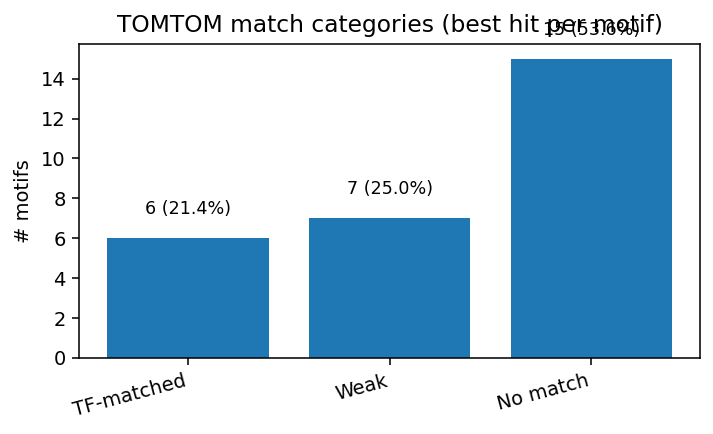

In [8]:
# Build a counts table; if we have the MEME list, add 'No hit' motifs explicitly.
plot_df = best.copy()

if all_query_motifs is not None:
    hit_motifs = set(plot_df[query_col].astype(str))
    missing = [m for m in all_query_motifs if m not in hit_motifs]
    if missing:
        extra = pd.DataFrame({query_col: missing, qval_col: np.nan, "match_class": "No match"})
        plot_df = pd.concat([plot_df, extra], ignore_index=True)

counts = plot_df["match_class"].value_counts().reindex(["TF-matched","Weak","No match"]).fillna(0).astype(int)

fig, ax = plt.subplots(figsize=(5.2,3.2))
ax.bar(counts.index, counts.values)
ax.set_title("TOMTOM match categories (best hit per motif)")
ax.set_ylabel("# motifs")
ax.set_xticklabels(counts.index, rotation=15, ha="right")

total = counts.sum()
for i, (k, v) in enumerate(counts.items()):
    ax.text(i, v + max(1, total*0.01), f"{v} ({v/total:.1%})", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


## 4) Plot: Top TF targets (from TOMTOM)

This is **not** gene expression. It’s *similarity to TF binding motifs in JASPAR*. We only use **TF-matched** (high-confidence) by default.

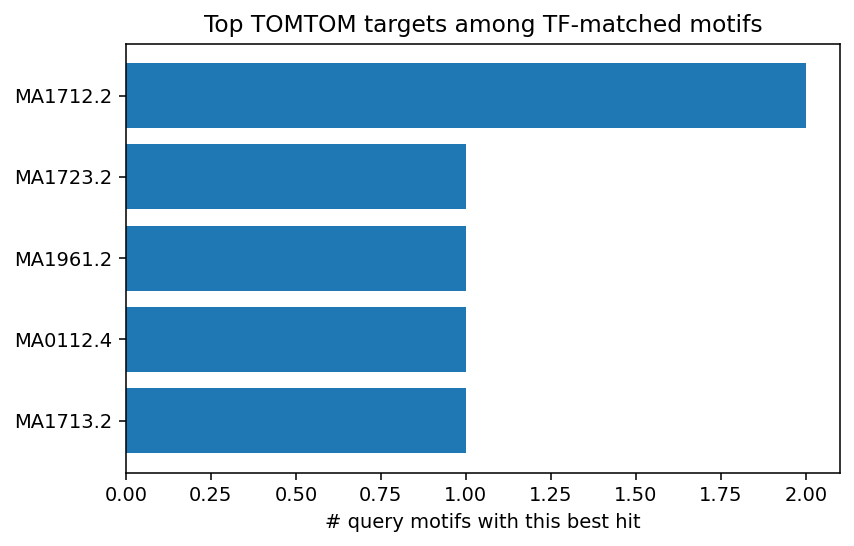

In [9]:
tf_matched = best[best["match_class"] == "TF-matched"].copy()
if tf_matched.empty:
    print("No TF-matched motifs under the default thresholds (q<=0.05, overlap>=8).")
else:
    top = (tf_matched[target_col].astype(str)
           .value_counts()
           .head(15))
    fig, ax = plt.subplots(figsize=(6.2,4.0))
    ax.barh(top.index[::-1], top.values[::-1])
    ax.set_title("Top TOMTOM targets among TF-matched motifs")
    ax.set_xlabel("# query motifs with this best hit")
    plt.tight_layout()
    plt.show()


## 5) Plot: q-value distribution (best hit per motif)

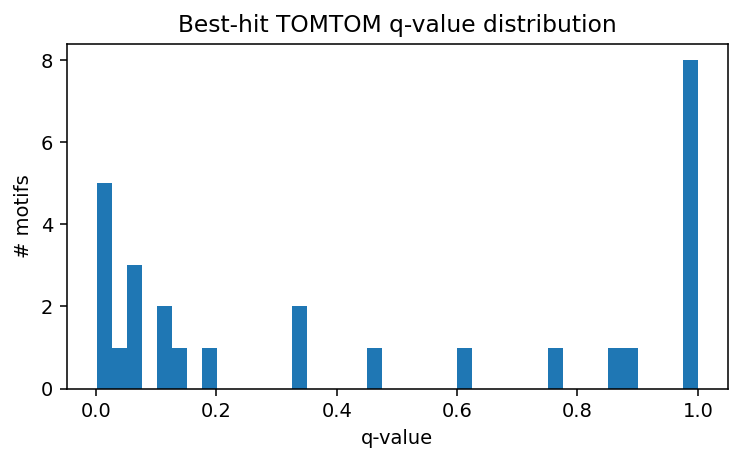

In [10]:
fig, ax = plt.subplots(figsize=(5.4,3.4))
vals = best[qval_col].replace([np.inf, -np.inf], np.nan).dropna().astype(float)
ax.hist(vals, bins=40)
ax.set_title("Best-hit TOMTOM q-value distribution")
ax.set_xlabel("q-value")
ax.set_ylabel("# motifs")
plt.tight_layout()
plt.show()


## 6) Representative attribution plot from one sample

This selects the **highest-confidence** sample from `metadata.csv` (if present), loads its `.npy` saliency array, and plots:

- global 64 kb saliency
- zoomed-in top 200 bp window


In [11]:
def load_metadata(meta_path: Path) -> pd.DataFrame | None:
    if not meta_path.exists():
        return None
    df = pd.read_csv(meta_path)
    return df

meta = load_metadata(METADATA_CSV)
if meta is None:
    print(f"ℹ️ No metadata.csv found at {METADATA_CSV}. We'll pick an arbitrary .npy file.")
else:
    print("✅ metadata rows:", len(meta))
    meta.head()


✅ metadata rows: 2575


In [12]:
# Pick one sample
if meta is not None and "confidence" in meta.columns and "file" in meta.columns:
    row = meta.sort_values("confidence", ascending=False).iloc[0]
    sal_path = SALIENCY_DIR / row["file"]
    title_info = f"Top-confidence sample: conf={row['confidence']:.3f} | {row.get('chrom','')}:{row.get('start','')}"
else:
    # fallback: pick any .npy
    npys = sorted(SALIENCY_DIR.glob("*.npy"))
    assert npys, f"No .npy files found under {SALIENCY_DIR.resolve()}"
    sal_path = npys[0]
    title_info = f"Example saliency file: {sal_path.name}"

assert sal_path.exists(), f"Missing saliency file: {sal_path.resolve()}"
sal = np.load(sal_path)

print(title_info)
print("Saliency shape:", sal.shape, "dtype:", sal.dtype, "min/max:", float(np.min(sal)), float(np.max(sal)))


Top-confidence sample: conf=0.997 | chr1:46769968
Saliency shape: (65536,) dtype: float32 min/max: -0.09512417018413544 0.15368899703025818


In [13]:
def top_windows_from_saliency(saliency_1d: np.ndarray, win=200, topk=10, min_gap=200):
    s = np.maximum(saliency_1d, 0.0)  # positive only
    # sliding window sum via convolution
    window_sums = np.convolve(s, np.ones(win, dtype=np.float32), mode="valid")
    # greedy non-overlap selection
    chosen = []
    taken = np.zeros(len(window_sums), dtype=bool)

    # indices sorted by descending score
    order = np.argsort(window_sums)[::-1]
    for idx in order:
        if len(chosen) >= topk:
            break
        # enforce min gap in terms of start positions
        if any(abs(idx - c) < min_gap for c in chosen):
            continue
        chosen.append(int(idx))
    chosen.sort()
    return chosen, window_sums

starts, window_sums = top_windows_from_saliency(sal, win=WIN, topk=TOPK, min_gap=MIN_GAP)
starts[:10], len(starts)


([27422, 27761, 27961, 30604, 36455, 37026, 37226, 37441, 37678, 38068], 10)

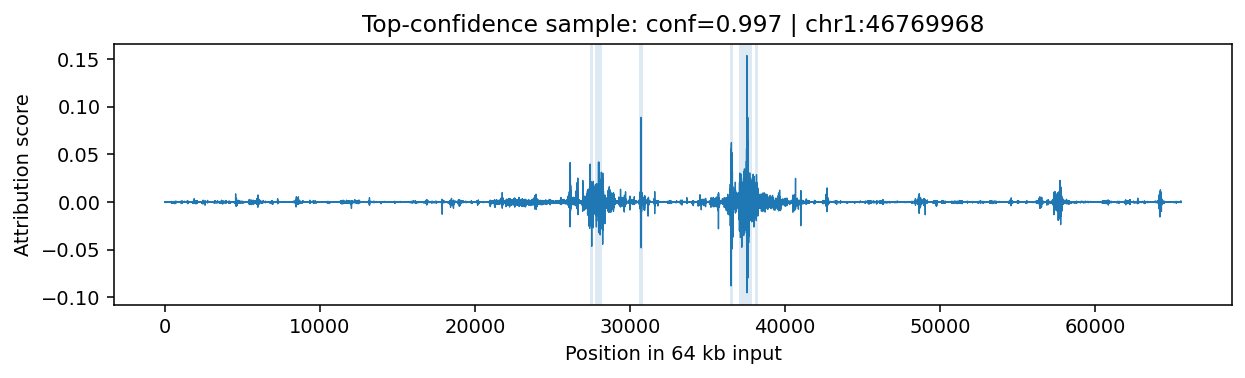

In [14]:
# Global plot
x = np.arange(len(sal))
fig, ax = plt.subplots(figsize=(9,2.8))
ax.plot(x, sal, linewidth=0.7)
ax.set_title(title_info)
ax.set_xlabel("Position in 64 kb input")
ax.set_ylabel("Attribution score")

# highlight selected windows
for st in starts:
    ax.axvspan(st, st+WIN, alpha=0.15)

plt.tight_layout()
plt.show()


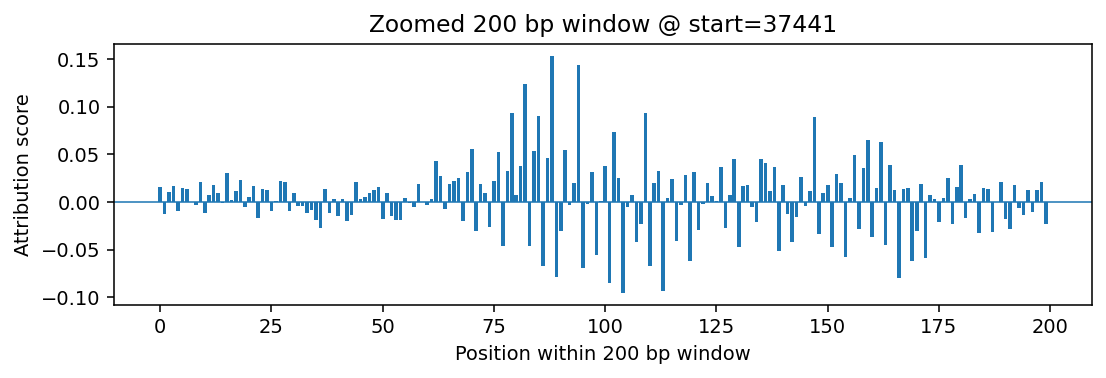

In [15]:
# Zoom into the top window (highest window sum)
top_idx = int(np.argmax([window_sums[s] for s in starts])) if starts else int(np.argmax(window_sums))
zoom_start = starts[top_idx] if starts else top_idx
zoom = sal[zoom_start:zoom_start+WIN]

fig, ax = plt.subplots(figsize=(8,2.8))
ax.bar(np.arange(WIN), zoom, linewidth=1.2)
ax.set_title(f"Zoomed 200 bp window @ start={zoom_start}")
ax.set_xlabel("Position within 200 bp window")
ax.set_ylabel("Attribution score")
ax.axhline(0, linewidth=0.8)
plt.tight_layout()
plt.show()


## 7) (Optional) Join TOMTOM hits with your motif stats

If you have `*.motif_stats.csv` from your exporter, we can make a nicer summary table and plot **seqlet count vs match class**.

In [16]:
if MOTIF_STATS.exists():
    stats = pd.read_csv(MOTIF_STATS)
    stats.columns = [c.strip().lower() for c in stats.columns]
    # try to detect motif id column
    mid = None
    for c in ["motif_id","motif","pattern","name","id"]:
        if c in stats.columns:
            mid = c
            break
    if mid is None:
        print("Found motif stats but couldn't detect motif id column. Columns:", list(stats.columns))
    else:
        merged = stats.merge(best[[query_col, "match_class", qval_col, target_col]], left_on=mid, right_on=query_col, how="left")
        merged["match_class"] = merged["match_class"].fillna("No match")
        display(merged.head())

        if "n_seqlets" in merged.columns:
            fig, ax = plt.subplots(figsize=(5.6,3.6))
            # simple jittered strip via random x offsets
            classes = ["TF-matched","Weak","No match"]
            for i, cls in enumerate(classes):
                y = merged.loc[merged["match_class"]==cls, "n_seqlets"].dropna().astype(float).values
                if len(y)==0: 
                    continue
                x = np.random.normal(i, 0.06, size=len(y))
                ax.scatter(x, y, s=10, alpha=0.6)
            ax.set_xticks(range(3))
            ax.set_xticklabels(classes, rotation=15, ha="right")
            ax.set_ylabel("# seqlets")
            ax.set_yscale("log")
            ax.set_title("Seqlet counts by TOMTOM match class (log scale)")
            plt.tight_layout()
            plt.show()
else:
    print("ℹ️ MOTIF_STATS not found; skip.")


ℹ️ MOTIF_STATS not found; skip.


Index(['Query_ID', 'Target_ID', 'Optimal_offset', 'p-value', 'E-value',
       'q-value', 'Overlap', 'Query_consensus', 'Target_consensus',
       'Orientation'],
      dtype='object')


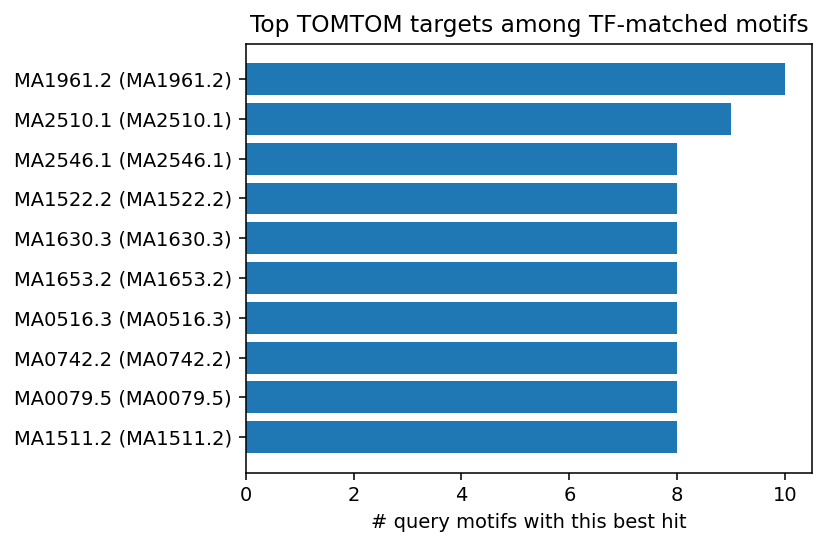

In [17]:
# information.ipynb

## TOMTOM: Map JASPAR Matrix IDs to TF Names

import pandas as pd
import matplotlib.pyplot as plt

# Load TOMTOM results
tomtom = pd.read_csv("tomtom_large_sample.tsv", sep="\t")

# Inspect available columns
print(tomtom.columns)

# Prefer using Target_Name if present
if "Target_Name" in tomtom.columns:
    id_to_name = (
        tomtom[["Target_ID", "Target_Name"]]
        .drop_duplicates()
        .set_index("Target_ID")["Target_Name"]
        .to_dict()
    )
else:
    # Fallback: parse JASPAR PFM file to map MA IDs -> TF names
    id_to_name = {}
    with open("JASPAR2022_CORE_non-redundant_pfms_jaspar.txt") as f:
        for line in f:
            if line.startswith(">"):
                # Example header: >MA1712.2 ZNF143
                parts = line[1:].strip().split()
                if len(parts) >= 2:
                    id_to_name[parts[0]] = parts[1]

# Example aggregation: count best-hit targets
# (adjust to match how you defined "best hit")
counts = (
    tomtom.groupby("Target_ID")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(10)
)

# Build readable labels
counts["TF"] = counts["Target_ID"].map(id_to_name).fillna(counts["Target_ID"])
counts["label"] = counts["TF"] + " (" + counts["Target_ID"] + ")"

# Plot
plt.figure(figsize=(6,4))
plt.barh(counts["label"], counts["count"])
plt.xlabel("# query motifs with this best hit")
plt.title("Top TOMTOM targets among TF-matched motifs")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [18]:
import pandas as pd
import requests

tomtom = pd.read_csv("tomtom_large_sample.tsv", sep="\t")

# Unique JASPAR matrix IDs from your TOMTOM results
unique_ids = tomtom["Target_ID"].dropna().unique().tolist()

id_to_name = {}
for mid in unique_ids:
    url = f"https://jaspar.elixir.no/api/v1/matrix/{mid}/?format=json"
    r = requests.get(url, timeout=30)
    if r.status_code == 200:
        id_to_name[mid] = r.json().get("name", mid)
    else:
        id_to_name[mid] = mid  # fallback if not found

print("Mapped:", len(id_to_name))
print(list(id_to_name.items())[:10])


Mapped: 275
[('MA1712.2', 'ZNF454'), ('MA2546.1', 'ZNF131'), ('MA2681.1', 'KLF8'), ('MA2510.1', 'ZBTB41'), ('MA2328.1', 'ZBED4'), ('MA2538.1', 'CGGBP1'), ('MA2583.1', 'ZNF142'), ('MA0742.2', 'KLF12'), ('MA0753.3', 'ZNF740'), ('MA1548.2', 'PLAGL2')]


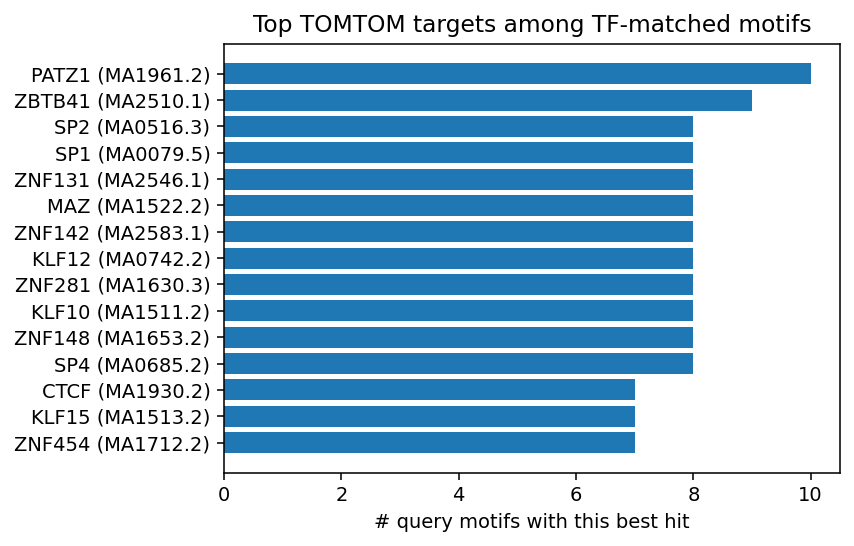

In [19]:
top = tomtom["Target_ID"].value_counts().head(15)
labels = [f"{id_to_name.get(mid, mid)} ({mid})" for mid in top.index]

import matplotlib.pyplot as plt
plt.figure(figsize=(6.2, 4.0))
plt.barh(labels[::-1], top.values[::-1])
plt.xlabel("# query motifs with this best hit")
plt.title("Top TOMTOM targets among TF-matched motifs")
plt.tight_layout()
plt.show()


In [20]:
tomtom
tomtom[tomtom['q-value'] <= 0.05]

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,POS_0,MA1712.2,-12.0,8.480380e-07,0.000864,0.001679,17.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCCCGGGGCCCGGAGCC,-
1,POS_0,MA2546.1,0.0,5.846910e-06,0.005958,0.005787,13.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCGCGCCCGCGCC,+
2,POS_0,MA2681.1,-25.0,1.376550e-05,0.014027,0.008645,11.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GGGGGCGGGGC,+
3,POS_0,MA2510.1,-14.0,1.746760e-05,0.017799,0.008645,18.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GGGGGCCCGCGAGGGGGG,+
4,POS_0,MA2328.1,-29.0,3.290150e-05,0.033527,0.013026,10.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GCGGGGCGGG,-
5,POS_0,MA2538.1,-5.0,6.958950e-05,0.070912,0.019680,12.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCGCCGCCGCCG,+
6,POS_0,MA2583.1,-26.0,9.676200e-05,0.098600,0.021283,12.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GCGGGCGGGCGG,-
7,POS_0,MA0742.2,-26.0,1.306650e-04,0.133147,0.024136,9.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GGGGCGGGG,+
8,POS_0,MA0753.3,-5.0,1.440430e-04,0.146780,0.024136,10.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCCCCCCCAC,+
9,POS_0,MA1548.2,-2.0,1.463060e-04,0.149085,0.024136,8.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GGGCCCCC,+


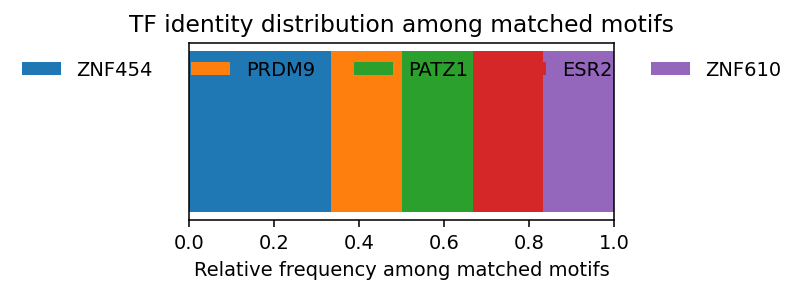

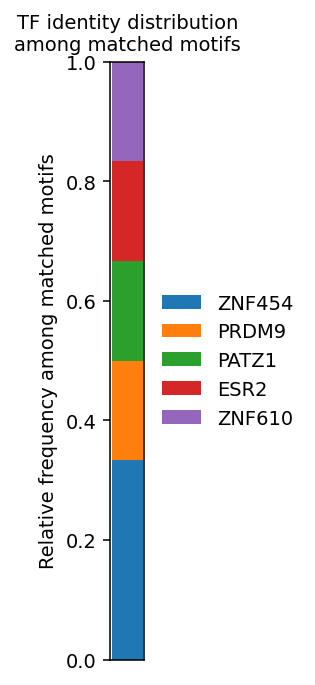

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tomtom = pd.read_csv("tomtom_large_sample.tsv", sep="\t")

# Clean q-values
tomtom["q-value"] = pd.to_numeric(tomtom["q-value"], errors="coerce")
tt = tomtom.dropna(subset=["Query_ID", "q-value"]).copy()

# Best hit per motif
best_idx = tt.groupby("Query_ID")["q-value"].idxmin()
best = tt.loc[best_idx].copy()

# Keep only matched motifs
q_thresh = 0.05
best = best[best["q-value"] <= q_thresh].copy()

# Map IDs -> TF names
best["TF"] = best["Target_ID"].map(id_to_name).fillna(best["Target_ID"])

# Top N TFs
# Top N TFs
N = 6   # <-- increase this (try 10–20)
top_tfs = best["TF"].value_counts().head(N)
top_set = set(top_tfs.index)

# Bucket (keep only top TFs)
best["bucket"] = best["TF"].apply(lambda tf: tf if tf in top_set else None)

props = best["bucket"].value_counts(normalize=True)

order = list(top_tfs.index)
props = props.reindex(order).fillna(0)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(5, 2.2))  # slightly taller
left = 0
for label, val in props.items():
    ax.barh([""], [val], left=left, label=label)
    left += val

ax.set_xlim(0, 1)
ax.set_yticks([])
ax.set_xlabel("Relative frequency among matched motifs")
ax.set_title("TF identity distribution among matched motifs")

# IMPORTANT: more columns so legend doesn't collapse
ax.legend(
    ncol=5,                    # <-- increase columns
    bbox_to_anchor=(0.5, 1),
    loc="upper center",
    frameon=False
)

plt.tight_layout()
plt.show()
fig, ax = plt.subplots(figsize=(2.2, 5.0))  # narrow & tall

bottom = 0
for label, val in props.items():
    ax.bar([0], [val], bottom=bottom, width=0.6, label=label)
    bottom += val

ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_ylabel("Relative frequency among matched motifs")
ax.set_title("TF identity distribution\namong matched motifs", fontsize=10)

# Put legend to the right WITHOUT stretching figure
ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),   # just outside axes
    frameon=False
)

plt.tight_layout()
plt.show()


In [22]:
tomtom.head(10)

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
0,POS_0,MA1712.2,-12.0,8.480380e-07,0.000864,0.001679,17.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCCCGGGGCCCGGAGCC,-
1,POS_0,MA2546.1,0.0,5.846910e-06,0.005958,0.005787,13.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCGCGCCCGCGCC,+
2,POS_0,MA2681.1,-25.0,1.376550e-05,0.014027,0.008645,11.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GGGGGCGGGGC,+
3,POS_0,MA2510.1,-14.0,1.746760e-05,0.017799,0.008645,18.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GGGGGCCCGCGAGGGGGG,+
4,POS_0,MA2328.1,-29.0,3.290150e-05,0.033527,0.013026,10.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GCGGGGCGGG,-
5,POS_0,MA2538.1,-5.0,6.958950e-05,0.070912,0.019680,12.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCGCCGCCGCCG,+
6,POS_0,MA2583.1,-26.0,9.676200e-05,0.098600,0.021283,12.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GCGGGCGGGCGG,-
7,POS_0,MA0742.2,-26.0,1.306650e-04,0.133147,0.024136,9.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GGGGCGGGG,+
8,POS_0,MA0753.3,-5.0,1.440430e-04,0.146780,0.024136,10.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,CCCCCCCCAC,+
9,POS_0,MA1548.2,-2.0,1.463060e-04,0.149085,0.024136,8.0,CGGGGCCCCCGCCACCGGCGCCGCGAGCGGCGGGGCGGCCCCGGCG...,GGGCCCCC,+


Using samples: 500


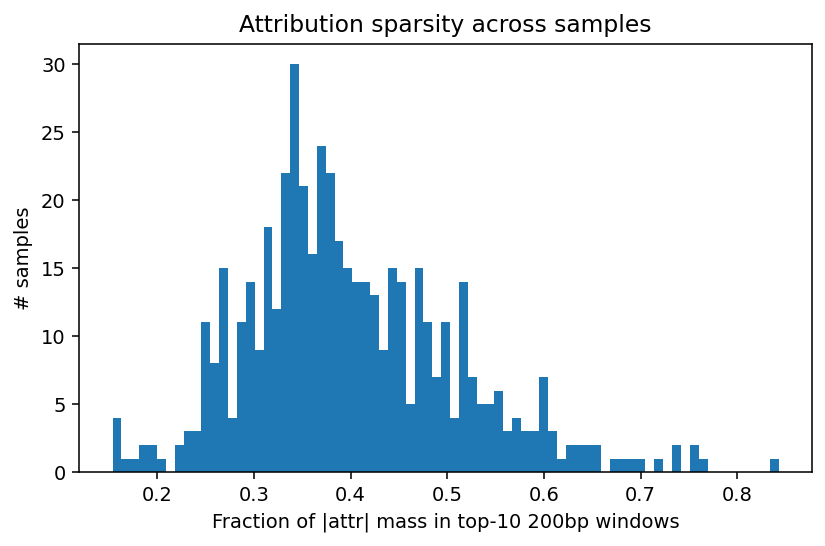

Saved plot_enh_vs_prom_mass.png


/var/folders/1r/8kyrcg852fgf6nffdk5rw72w0000gn/T/ipykernel_81017/2602222368.py:110: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


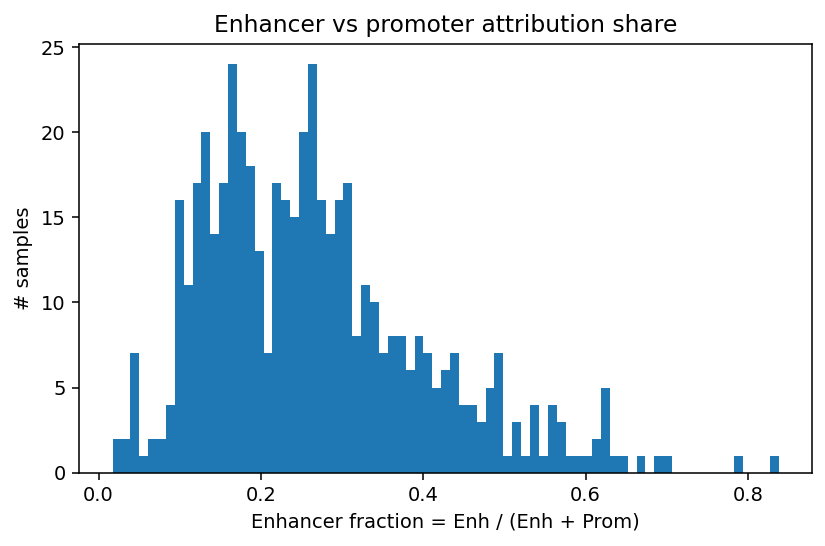

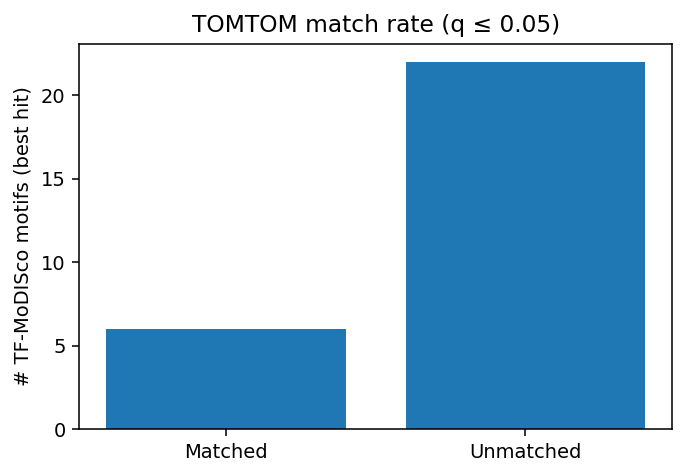


Summary:
TopK sparsity (median): 0.38039684295654297
Matched motifs: 6 Unmatched motifs: 22


In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# CONFIG (edit if needed)
# -----------------------
SAL_DIR = "saliency_scores_2"
META_CSV = os.path.join(SAL_DIR, "metadata.csv")
PARQUET_PATH = "GM12878_RNAPII_64k_strict.parquet"
TOMTOM_TSV = "tomtom_large_sample.tsv"

SEQ_LEN = 65536
WIN = 200
TOPK = 10
MAX_SAMPLES = 500  # keep runtime reasonable; increase if you want

TOMTOM_Q = 0.05  # significance threshold for "matched"

# -----------------------
# Helper: compute window sums
# -----------------------
def topk_fraction_abs(attr_1d, win=200, topk=10):
    """Fraction of total |attr| mass captured by top-k non-overlapping windows (approx using stride=win)."""
    a = np.abs(attr_1d[:SEQ_LEN])
    if a.sum() == 0:
        return np.nan
    # Fast binning into non-overlapping 200bp chunks
    n = (len(a) // win) * win
    chunks = a[:n].reshape(-1, win).sum(axis=1)
    top = np.sort(chunks)[-topk:].sum()
    return float(top / chunks.sum())

def region_abs_sum(attr_1d, start, end):
    start = max(0, int(start))
    end = min(len(attr_1d), int(end))
    if end <= start:
        return 0.0
    return float(np.abs(attr_1d[start:end]).sum())

# -----------------------
# Load metadata + parquet to get enhancer/promoter coords
# -----------------------
meta = pd.read_csv(META_CSV)
df = pd.read_parquet(PARQUET_PATH)

# Join metadata back to parquet rows by (chrom, win_start)
# Your metadata has "chrom" and "start" (win_start)
df_keyed = df.copy()
df_keyed["start"] = df_keyed["win_start"].astype(int)

merged = meta.merge(
    df_keyed[["chrom", "start", "enh_rel_start", "enh_rel_end", "prom_rel_start", "prom_rel_end"]],
    on=["chrom", "start"],
    how="left"
)

# Keep only rows where we have coords and the file exists
merged["path"] = merged["file"].apply(lambda fn: os.path.join(SAL_DIR, fn))
merged = merged[merged["path"].apply(os.path.exists)].copy()
merged = merged.dropna(subset=["enh_rel_start", "enh_rel_end", "prom_rel_start", "prom_rel_end"])

# Subsample for speed
merged = merged.head(MAX_SAMPLES).reset_index(drop=True)
print("Using samples:", len(merged))

# -----------------------
# Compute per-sample stats
# -----------------------
topk_fracs = []
enh_mass = []
prom_mass = []
ratio = []

for _, r in merged.iterrows():
    arr = np.load(r["path"])
    # safety
    if arr.shape[0] < SEQ_LEN:
        continue
    # sparsity
    topk_fracs.append(topk_fraction_abs(arr, win=WIN, topk=TOPK))
    # enhancer/promoter absolute attribution mass
    e = region_abs_sum(arr, r["enh_rel_start"], r["enh_rel_end"])
    p = region_abs_sum(arr, r["prom_rel_start"], r["prom_rel_end"])
    enh_mass.append(e)
    prom_mass.append(p)
    denom = e + p
    ratio.append(e / denom if denom > 0 else np.nan)

topk_fracs = np.array(topk_fracs, dtype=float)
enh_mass = np.array(enh_mass, dtype=float)
prom_mass = np.array(prom_mass, dtype=float)
ratio = np.array(ratio, dtype=float)

# -----------------------
# PLOT 1: Attribution sparsity
# -----------------------
plt.figure(figsize=(6,4))
plt.hist(topk_fracs[~np.isnan(topk_fracs)], bins=75)
plt.xlabel(f"Fraction of |attr| mass in top-{TOPK} {WIN}bp windows")
plt.ylabel("# samples")
plt.title("Attribution sparsity across samples")
plt.tight_layout()
plt.show()
# -----------------------
# PLOT 2: Enhancer vs promoter mass
# -----------------------
plt.figure(figsize=(6,4))
plt.boxplot(
    [enh_mass, prom_mass],
    labels=["Enhancer", "Promoter"],
    showfliers=False
)
plt.ylabel("Sum of |attr| within region")
plt.title("Attribution mass in enhancer vs promoter")
plt.tight_layout()
plt.savefig("plot_enh_vs_prom_mass.png", dpi=200)
plt.close()
print("Saved plot_enh_vs_prom_mass.png")

plt.figure(figsize=(6,4))
plt.hist(ratio[~np.isnan(ratio)], bins=75)
plt.xlabel("Enhancer fraction = Enh / (Enh + Prom)")
plt.ylabel("# samples")
plt.title("Enhancer vs promoter attribution share")
plt.tight_layout()
plt.show()

# -----------------------
# PLOT 3: Motif matched vs unmatched (from TOMTOM best-hit per query motif)
# -----------------------
tomtom = pd.read_csv(TOMTOM_TSV, sep="\t")

# Robust: ensure numeric q-value
qcol = "q-value" if "q-value" in tomtom.columns else "qvalue"
tomtom[qcol] = pd.to_numeric(tomtom[qcol], errors="coerce")

# Drop NaNs and pick best (lowest q) per Query_ID
tomtom2 = tomtom.dropna(subset=["Query_ID", qcol]).copy()
best_idx = tomtom2.groupby("Query_ID")[qcol].idxmin()
best = tomtom2.loc[best_idx].copy()

matched = (best[qcol] <= TOMTOM_Q).sum()
unmatched = (best[qcol] > TOMTOM_Q).sum()

plt.figure(figsize=(5,3.5))
plt.bar(["Matched", "Unmatched"], [matched, unmatched])
plt.ylabel("# TF-MoDISco motifs (best hit)")
plt.title(f"TOMTOM match rate (q ≤ {TOMTOM_Q})")
plt.tight_layout()
plt.show()

print("\nSummary:")
print("TopK sparsity (median):", np.nanmedian(topk_fracs))
print("Matched motifs:", matched, "Unmatched motifs:", unmatched)
